# Домашее задание №3

## Задание 1

В файле Worldbank_tech.xlsx содержаться данные Всемирного банка по ряду показателей по странам. В файле следующие переменные:
    
    - country_name: Country Name
    - country_code: Country Code
    - internet: Internet users (per 100 people)
    - secure: Secure Internet servers (per 1 million people)
    - export: Communications, computer, etc. (% of service exports)
    - import: Communications, computer, etc. (% of service imports)
    - telephone: Fixed telephone subscriptions (per 100 people)
    - hightech: High-technology exports (current US$)
    - mobile: Mobile cellular subscriptions (per 100 people)
    

Проведите иерархический кластерный анализ данных с использованием не менее 4-х метрических переменных. Выполните следующие пункты:

        1.	Обоснуйте выбор переменных кластеризации.

        2.	Выберите оптимальный метод иерархической кластеризации и обоснуйте свой выбор.

        3.	Создайте дендрограмму, опишите её.

        4.	Определите число кластеров, объясните своё решение.

        5.	Опишите получившиеся кластеры на основе описательной статистки. Нужно не просто рассчитать статистики в таблицах, но детально описать полученные результаты.

        6.	Дайте названия кластерам и обоснуйте их.

        7.	Почему получилась именно такая кластерная структура? Полученные результаты соответствуют вашем изначальным предположениям или оказались неожиданными?

In [ ]:
import pandas as pd
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
import warnings
import scipy.stats as stats
warnings.filterwarnings("ignore")
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

C:\Users\Ann\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Ann\Anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [ ]:
data = pd.read_excel('Worldbank_tech.xlsx')
data.head()

,country_name,country_code,internet,secure,export,import,telephone,hightech,mobile
0,Afghanistan,AFG,8.260000,1.414229,72.652794,9.053154,0.343677,NaN,61.577619
1,Albania,ALB,63.252933,37.727137,25.303169,11.124101,7.091628,15123662.0,106.380207
2,Algeria,DZA,38.200000,2.546228,59.256825,58.012028,8.041628,2449466.0,113.031094
3,American Samoa,ASM,NaN,72.022759,NaN,NaN,18.005690,NaN,NaN
4,Andorra,ADO,96.910000,1631.830630,NaN,NaN,47.992588,NaN,88.123533


Для иерархического кластерного анализа нам нужно выбрать переменные, которые могут отражать схожесть и различия между странами по технологическому развитию. В данном случае можно выбрать следующие четыре метрические переменные:

internet: Количество пользователей интернета на 100 человек.
secure: Количество защищенных интернет-серверов на 1 миллион человек.
mobile: Количество мобильных телефонных подписок на 100 человек.
hightech: Экспорт высоких технологий.
Эти переменные позволют оценить доступность и использование технологий, что важно для кластеризации стран по уровню технологического развития.

Теперь проверим данные и подготовим их к проведению кластерного анализа:
Переменные не должны коррелировать и должны иметь схожую шкалу
измерения.

Чтобы выбрать критерий для определния корреляции, исследуем данные на нормальность.
Для нашей выборки больше подходит тест Колмогорова-Смирнова, поскольку размер выборки превышает 50.

In [ ]:
for column in ['internet', 'secure', 'mobile', 'hightech']:
    data_clean = data[column].dropna()
    d_statistic, p_value = stats.kstest(data_clean, 'norm', args=(data_clean.mean(), data_clean.std()))
    print(f'Тест Колмогорова-Смирнова для {column}: Статистика={d_statistic:.3f}, p-значение={p_value:.3f}')
    if p_value > 0.05:
        print(f"{column} имеет нормальное распределение (не отклоняем нулевую гипотезу).")
    else:
        print(f"{column} не имеет нормального распределения (отклоняем нулевую гипотезу).")

Тест Колмогорова-Смирнова для internet: Статистика=0.109, p-значение=0.015
internet не имеет нормального распределения (отклоняем нулевую гипотезу).
Тест Колмогорова-Смирнова для secure: Статистика=0.342, p-значение=0.000
secure не имеет нормального распределения (отклоняем нулевую гипотезу).
Тест Колмогорова-Смирнова для mobile: Статистика=0.061, p-значение=0.422
mobile имеет нормальное распределение (не отклоняем нулевую гипотезу).
Тест Колмогорова-Смирнова для hightech: Статистика=0.394, p-значение=0.000
hightech не имеет нормального распределения (отклоняем нулевую гипотезу).


Получим, что только mobile имеет нормальное, значит, везде можем воспользоваться коэффициетом Спирмена.

In [ ]:
data = data.dropna(subset=['internet', 'import', 'mobile', 'hightech'])
variables = ['internet', 'secure', 'mobile', 'hightech']
for i in range(len(variables)):
    for j in range(i + 1, len(variables)):
        var1 = variables[i]
        var2 = variables[j]
        corr, p = stats.spearmanr(data[var1], data[var2])
        print(f'Коэффициент корреляции Спирмена между {var1} и {var2}: {corr:.3f}')

Коэффициент корреляции Спирмена между internet и secure: 0.891
Коэффициент корреляции Спирмена между internet и mobile: 0.318
Коэффициент корреляции Спирмена между internet и hightech: 0.539
Коэффициент корреляции Спирмена между secure и mobile: 0.308
Коэффициент корреляции Спирмена между secure и hightech: 0.510
Коэффициент корреляции Спирмена между mobile и hightech: 0.256


между internet и secure сильная корреляция, заменим эту перменную на import в нашем анализе

In [ ]:
for column in ['internet', 'import', 'mobile', 'hightech']:
    data_clean = data[column].dropna()
    d_statistic, p_value = stats.kstest(data_clean, 'norm', args=(data_clean.mean(), data_clean.std()))
    print(f'Тест Колмогорова-Смирнова для {column}: Статистика={d_statistic:.3f}, p-значение={p_value:.3f}')
    if p_value > 0.05:
        print(f"{column} имеет нормальное распределение (не отклоняем нулевую гипотезу).")
    else:
        print(f"{column} не имеет нормального распределения (отклоняем нулевую гипотезу).")

Тест Колмогорова-Смирнова для internet: Статистика=0.080, p-значение=0.521
internet имеет нормальное распределение (не отклоняем нулевую гипотезу).
Тест Колмогорова-Смирнова для import: Статистика=0.062, p-значение=0.820
import имеет нормальное распределение (не отклоняем нулевую гипотезу).
Тест Колмогорова-Смирнова для mobile: Статистика=0.081, p-значение=0.503
mobile имеет нормальное распределение (не отклоняем нулевую гипотезу).
Тест Колмогорова-Смирнова для hightech: Статистика=0.377, p-значение=0.000
hightech не имеет нормального распределения (отклоняем нулевую гипотезу).


Теперь получим, что для пары import и mobile нужно будет использовать коэффициент Пирсона, так как распределение нормально.

In [ ]:
data = data.dropna(subset=['internet', 'import', 'mobile', 'hightech'])
variables = ['internet', 'import', 'mobile', 'hightech']
for i in range(len(variables)):
    for j in range(i + 1, len(variables)):
        var1 = variables[i]
        var2 = variables[j]
        if not(i == 0 and j == 1):
            corr, p = stats.spearmanr(data[var1], data[var2])
            print(f'Коэффициент корреляции Спирмена между {var1} и {var2}: {corr:.3f}')

Коэффициент корреляции Спирмена между internet и mobile: 0.318
Коэффициент корреляции Спирмена между internet и hightech: 0.539
Коэффициент корреляции Спирмена между import и mobile: 0.169
Коэффициент корреляции Спирмена между import и hightech: 0.324
Коэффициент корреляции Спирмена между mobile и hightech: 0.256


In [ ]:
stats.pearsonr(data['import'], data['mobile'])

(0.11148719872137469, 0.27193187189897816)

Теперь нет переменных с сильной корреляцией, осталось их стандартизировать, как было показано на семинаре

In [ ]:
data['internet'] = (data['internet'] - data['internet'].mean()) / (data['internet'].std())
data['import'] = (data['import'] - data['import'].mean()) / (data['import'].std())
data['hightech'] = (data['hightech'] - data['hightech'].mean()) / (data['hightech'].std())
data['mobile'] = (data['mobile'] - data['mobile'].mean()) / (data['mobile'].std())

Определимся с методом иерархической кластеризации:

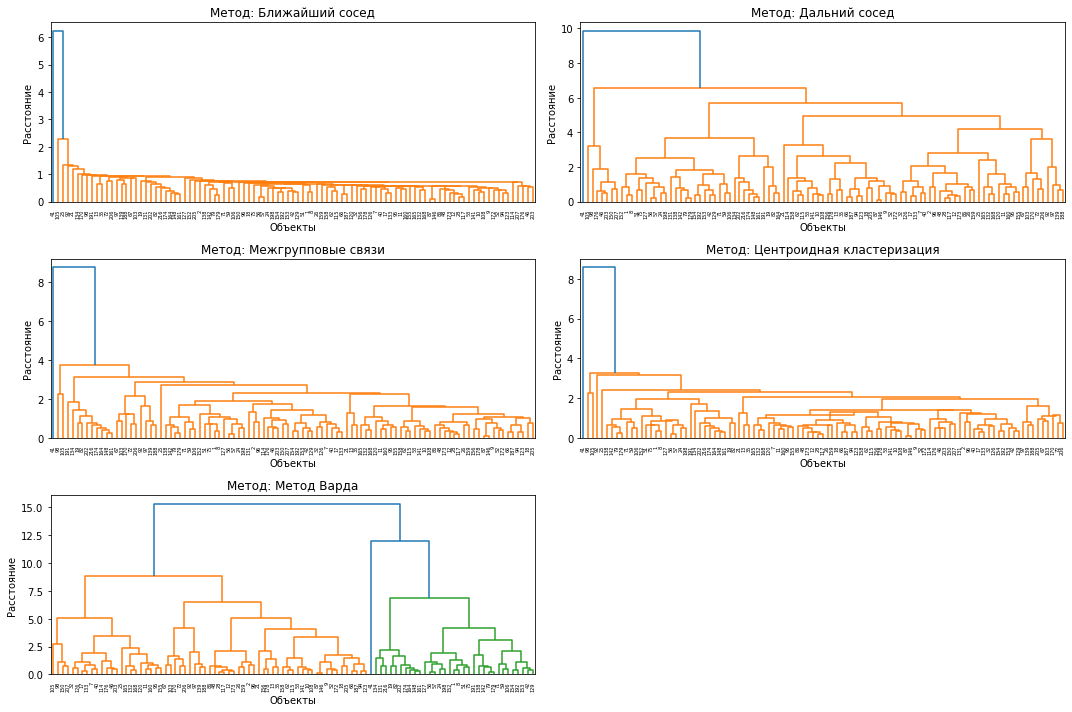

In [ ]:
X = data[variables]
methods = {
    'Ближайший сосед': 'single',
    'Дальний сосед': 'complete',
    'Межгрупповые связи': 'average',
    'Центроидная кластеризация': 'centroid',
    'Метод Варда': 'ward'
}


plt.figure(figsize=(15, 10))
for i, (method_name, method) in enumerate(methods.items()):
    plt.subplot(3, 2, i + 1)
    Z = linkage(X, method=method)
    dendrogram(Z, labels=data.index, leaf_rotation=90)
    plt.title(f'Метод: {method_name}')
    plt.xlabel('Объекты')
    plt.ylabel('Расстояние')

plt.tight_layout()
plt.show()

На первой, третьей и четвертой дендрограммах много цепочек, поэтому эти методы исключаем
Выбираем метод Варда, потому что имеем меньше цепочек и больше показательных кластеров,
чем при использовании метода Дальний сосед

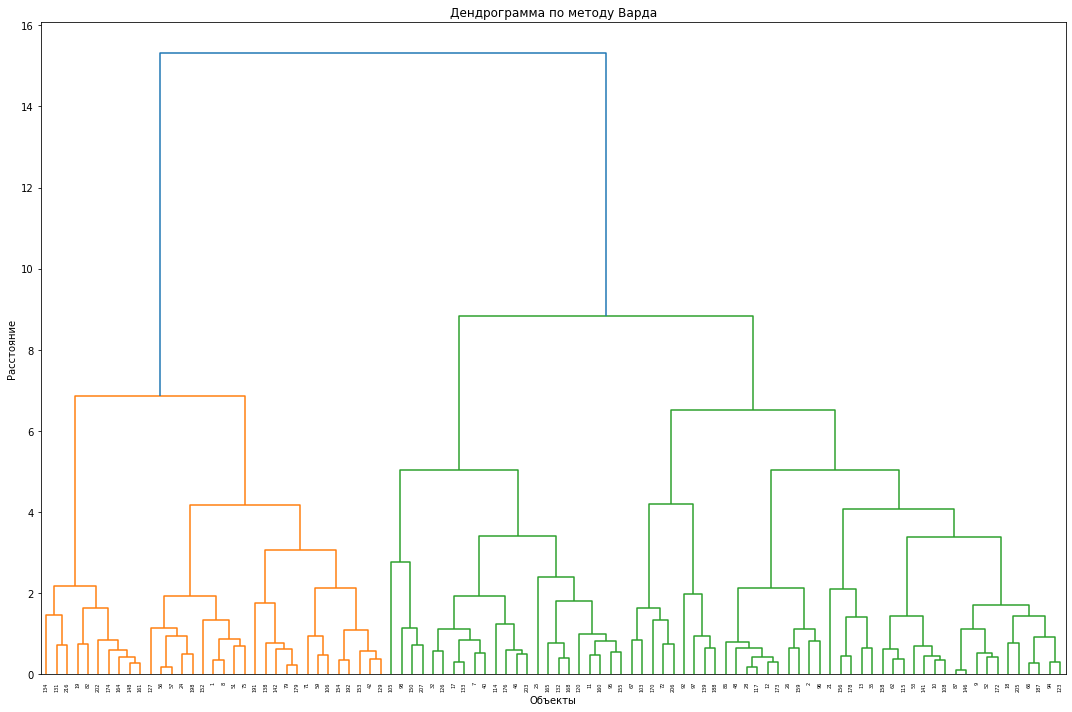

In [ ]:
data = data.drop(index=41) # Убрали выброс
X = data[variables]

# Построим дендрограммы по методу Варда, на ней меньше всего цепочек и больше показательных кластеров
plt.figure(figsize=(15, 10))
Z = linkage(X, method='ward')
dendrogram(Z, labels=data.index, leaf_rotation=90)
plt.title('Дендрограмма по методу Варда')
plt.xlabel('Объекты')
plt.ylabel('Расстояние')
plt.tight_layout()
plt.show()

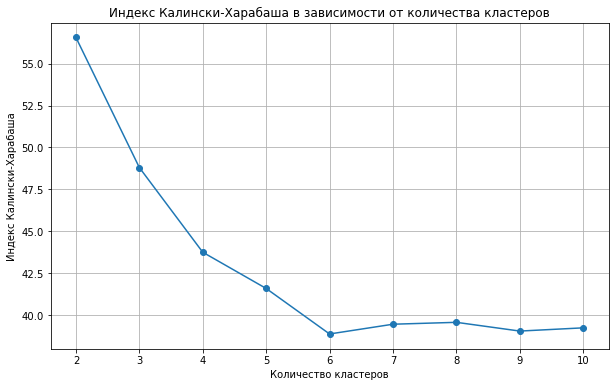

Оптимальное количество кластеров: 2


In [ ]:
from sklearn.metrics import calinski_harabasz_score
X = data[variables]

range_n_clusters = range(2, 11)
ch_scores = []

# Вычисление индекса Калински-Харабаша для каждого количества кластеров
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    labels = kmeans.labels_
    ch_score = calinski_harabasz_score(X, labels)
    ch_scores.append(ch_score)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, ch_scores, marker='o')
plt.title('Индекс Калински-Харабаша в зависимости от количества кластеров')
plt.xlabel('Количество кластеров')
plt.ylabel('Индекс Калински-Харабаша')
plt.xticks(range_n_clusters)
plt.grid()
plt.show()

# Оптимальное количество кластеров
optimal_n_clusters = range_n_clusters[np.argmax(ch_scores)]
print(f'Оптимальное количество кластеров: {optimal_n_clusters}')

In [ ]:
data['cluster_labels'] = fcluster(Z, t=2, criterion='maxclust')
data.groupby('cluster_labels')[['internet', 'import', 'hightech', 'mobile']].mean()
# из-за стандартизации вылезли отрицательные значения

,internet,import,hightech,mobile
cluster_labels,,,,
1,-1.001169,-0.835009,-0.261056,-0.761256
2,0.515420,0.442742,0.004224,0.399701


Исходя из результатов, первый кластер можно назвать технологически неразвитыми странами, второй - технологически развитыми.
Мы видим, что в первой группе гораздо меньше пользователей интернета на 100 человек, небольшой импорт технологической продукции,
относительно мало мобильных телефонных подписок на 100 человек, и невелик экспорт высоких технологий. Во второй группе по каждому
показателю количество больше. Так как мы стандартизировали шкалы, получили отрицательные значения, но это не мешает видеть явные
различия, в особенности в средних значениях переменных internet, но так же и в import и mobile.

Ожидания оправдались, правда, я предполагала выделение кластера "развивающихся" стран.
Но в целом ожиданемо, что по таким параметрам данные можно страны на развитые и отстающие.

In [ ]:
pip uninstall openpyxl

^C
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


## Задание 2

В файле Video_Games_Sales.csv содержаться данные о продажах видеоигр.
Источник: https://www.kaggle.com/rush4ratio/video-game-sales-with-ratings

В файле следующие переменные::
    
    - Name: The game’s name
    - Platform: Platform of the game’s release (i.e. PC, PS4, etc.)
    - Year_of_Release: Year of the game's release
    - Genre: Genre of the game
    - Publisher: Publisher of the game
    - NA_Sales: Sales in North America (in millions)
    - EU_Sales: Sales in Europe (in millions)
    - JP_Sales: Sales in Japan (in millions)
    - Other_Sales: Sales in the rest of the world (in millions)
    - Global_Sales: Total worldwide sales.
    - Critic_score: Aggregate score compiled by Metacritic staff
    - Criticcount: The number of critics used in coming up with the Criticscore
    - User_score: Score by Metacritic's subscribers
    - Usercount: Number of users who gave the userscore
    - Developer: Party responsible for creating the game
    - Rating: The ESRB ratings


Проведите кластерный анализ на основе алгоритмов k-средних или DBSCAN с использованием не менее 4-х метрических переменных. Выполните следующие пункты:

    1.Обоснуйте выбор переменных кластеризации.

    2.Выберите один из двух алгоритмов кластеризации (k-средних или DBSCAN) и обоснуйте свой выбор.

    3.Определите число кластеров, объясните своё решение.

    4.Опишите получившиеся кластеры с помощью описательной статистики. Нужно не просто рассчитать статистики в таблицах, но детально описать полученные результаты.

    5.Дайте названия кластерам и обоснуйте их.

    6.Почему получилась именно такая кластерная структура? Полученные результаты соответствуют вашем изначальным предположениям или оказались неожиданными?


In [ ]:
import pandas as pd
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
import warnings
from sklearn.metrics import calinski_harabasz_score
warnings.filterwarnings("ignore")

df = pd.read_csv('video_games_sales.csv')
df.head

C:\Users\Ann\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Ann\Anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


<bound method NDFrame.head of                                 Name Platform  Year_of_Release         Genre  \
0                         Wii Sports      Wii           2006.0        Sports   
1                  Super Mario Bros.      NES           1985.0      Platform   
2                     Mario Kart Wii      Wii           2008.0        Racing   
3                  Wii Sports Resort      Wii           2009.0        Sports   
4           Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing   
...                              ...      ...              ...           ...   
16714  Samurai Warriors: Sanada Maru      PS3           2016.0        Action   
16715               LMA Manager 2007     X360           2006.0        Sports   
16716        Haitaka no Psychedelica      PSV           2016.0     Adventure   
16717               Spirits & Spells      GBA           2003.0      Platform   
16718            Winning Post 8 2016      PSV           2016.0    Simulation   

         

In [ ]:
pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.


In [ ]:
variables = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Global_Sales']

Для кластеризации мы выберем следующие переменные:

NA_Sales: Продажи в Северной Америке
EU_Sales: Продажи в Европе
JP_Sales: Продажи в Японии
Global_Sales: Общие продажи по всему миру
Эти переменные являются количественными и отражают финансовый успех игр на различных рынках.
Они позволят нам оценить, как игры продаются в разных регионах и как это соотносится с их общей популярностью.

Выберем алгоритм K-средних для кластеризации:
KMeans хорошо работает с большими наборами данных и может быть эффективно использован для выявления четких кластеров.
Этот алгоритм требует, чтобы мы заранее определили количество кластеров, что позволяет нам более точно контролировать процесс кластеризации.
Он подходит для данных, которые имеют определенные центры, как в нашем случае с продажами.

In [ ]:
X = df[variables] # Данные и так имеют одну шкалу

# Определение числа кластеров с помощью метода локтя
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, inertia, marker='o')
plt.title('Метод локтя для выбора числа кластеров')
plt.xlabel('Количество кластеров')
plt.ylabel('Сумма квадратов расстояний (Inertia)')
plt.xticks(K)
plt.grid()
plt.show()



AttributeError: 'NoneType' object has no attribute 'split'

In [ ]:
for k in range (1, 11):
    labels = KMeans(n_clusters=k).fit_predict(X)
    print('Число кластеров: {}, индекс {}'.format(k, calinski_harabasz_score(X, labels)))

AttributeError: 'NoneType' object has no attribute 'split'

Получилось выделить 4 кластера по индексу Калински-Харабаша и методу Локтя, но потом что-то пошло не так с библиотеками
и код перестал запускаться... Получались 4 кластера по убываемости продаж, подробно посмотреть не успела. Отправлю отдельно.

Обратите внимание, что все пункты задания должны сопровождаться _выполненным_ фрагментом кода!

# Этот файл нужно сохранить как Notebook (.ipynb) и загрузить в Smart LMS до 13:00 30 октября.